In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


## Utility Functions

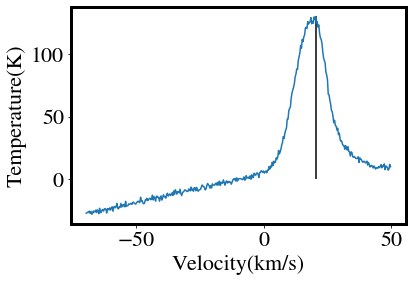

(129.7837525141532, 20.347246941143936)
(121.38441504686423, 18.00847902462882)


In [15]:
def calc_gain(main_data, on_data, off_data):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities(main_file=None):
    
    """
    A simple function to calculate the velocities
    """
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
    if main_file is None:
        correction = 0
        
    return (velocities + correction)
    

def calc_peak_max(main_file, on_file, off_file,main_fits):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
    on=fits.open(main_fits,memmap=True, do_not_scale_image_data=True)[0].header
    l, b, RA, DEC, JD = on[18], on[19], on[20], on[21], on[22]
    correction = ugradio.doppler.get_projected_velocity(RA, DEC,JD).value / 1000
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    #print(correction)
    T_NOISE = 90 # Kelvin
    
    G = calc_gain(main_data,on_data,off_data)
    max_value = np.max((main_data/off_data))
    max_index = np.argmax((main_data/off_data))
    velocities = calc_velocities()+correction
    
    
    fitting_indeces = np.where((velocities > -70) & (velocities < 50)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    max_value = np.max(y_data_fit[np.where(x_data_fit<40)])
    max_index = np.argmax(y_data_fit[np.where(x_data_fit<40)])
    T = max_value
    vel = x_data_fit[max_index]
    plt.plot(x_data_fit,y_data_fit)
    plt.vlines(vel,0,T)
    plt.ylabel('Temperature(K)')
    plt.xlabel('Velocity(km/s)')
    plt.show()
    return T, vel

def calc_peak_gaussian(main_file, on_file, off_file):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    
    velocities = calc_velocities()
    
    fitting_indeces = np.where((velocities > -50) & (velocities < 50)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    

    fit_params = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get fit
    
    
    T, vel = fit_params['amp'][0], fit_params['avg'][0]
                 
    return T,vel
                 
    

    
print(calc_peak_max("Data/celestial_main_105.000 , 15.000.npy",
              "Data/celestial_noise_on_105.000 , 15.000.npy", 
              "Data/celestial_noise_off_105.000 , 15.000.npy",'fits_files/celestial_main_105.000 , 15.000.fits')) 
print(calc_peak_gaussian("Data/celestial_main_105.000 , 15.000.npy",
              "Data/celestial_noise_on_105.000 , 15.000.npy", 
              "Data/celestial_noise_off_105.000 , 15.000.npy"))
    

## Loading in Data & Calculating

In [3]:
l_min, l_max = 105, 160
b_min, b_max = 15, 50

db = 2
dl = lambda b: 2/np.cos(b * (np.pi/180))

Δb = b_max - b_min
Δl = l_max - l_min

bs = np.array([b_min + i*db for i in range(50) if (b_min + i*db) < b_max])

ls = []
for b in bs:
    ls.append(np.array([l_min + i*dl(b) for i in range(50) if (l_min + i*dl(b)) < l_max]))

coords = []
for i in range(len(bs)):
    for j in range(len(ls[i])):
        coords.append([ls[i][j], bs[i]])

coords = np.array(coords)

coord_names = []
for coord in coords:
    coord_name = f"{coord[0]:0.3f} , {coord[1]:0.3f}"
    coord_names.append(coord_name)
coord_names

['105.000 , 15.000',
 '107.071 , 15.000',
 '109.141 , 15.000',
 '111.212 , 15.000',
 '113.282 , 15.000',
 '115.353 , 15.000',
 '117.423 , 15.000',
 '119.494 , 15.000',
 '121.564 , 15.000',
 '123.635 , 15.000',
 '125.706 , 15.000',
 '127.776 , 15.000',
 '129.847 , 15.000',
 '131.917 , 15.000',
 '133.988 , 15.000',
 '136.058 , 15.000',
 '138.129 , 15.000',
 '140.199 , 15.000',
 '142.270 , 15.000',
 '144.340 , 15.000',
 '146.411 , 15.000',
 '148.482 , 15.000',
 '150.552 , 15.000',
 '152.623 , 15.000',
 '154.693 , 15.000',
 '156.764 , 15.000',
 '158.834 , 15.000',
 '105.000 , 17.000',
 '107.091 , 17.000',
 '109.183 , 17.000',
 '111.274 , 17.000',
 '113.366 , 17.000',
 '115.457 , 17.000',
 '117.548 , 17.000',
 '119.640 , 17.000',
 '121.731 , 17.000',
 '123.822 , 17.000',
 '125.914 , 17.000',
 '128.005 , 17.000',
 '130.097 , 17.000',
 '132.188 , 17.000',
 '134.279 , 17.000',
 '136.371 , 17.000',
 '138.462 , 17.000',
 '140.554 , 17.000',
 '142.645 , 17.000',
 '144.736 , 17.000',
 '146.828 , 1

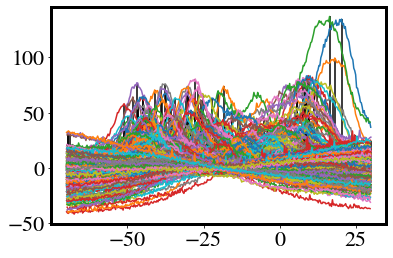

In [5]:
import glob

Temps, vels, indeces = [], [], []
for i, coord_name in enumerate(coord_names):
    
    on_file = glob.glob('Data/celestial_noise_on_' + coord_name + '*')
    off_file = glob.glob('Data/celestial_noise_off_' + coord_name + '*')
    main_file = glob.glob('Data/celestial_main_' + coord_name + '*')

    fits_file='fits_files/celestial_main_'+ coord_name + '.fits'
    if on_file and off_file and main_file:
        
        on_file = on_file[0]
        off_file = off_file[0] 
        main_file = main_file[0]
        
        T,V = calc_peak_max(main_file, on_file, off_file,fits_file)
        Temps.append(T)
        vels.append(V)
        indeces.append(i)
        
        
valid_coords = coords[indeces]
        

In [6]:
bad_indeces=np.array([171,195,196,220,232,267,268,279,280,281,282,283,284,301,302,303,304,305,306,307,314,320,323
,325,326,326,328,329,344,345,346,347,348,349,350,351,357,359,364,365,367,368,369,370,371,372,373,374,375,376,372,379,
382,385,387,388,390,391,392,394,395,396,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,
413,414,415,416,417,418,419,420,421,422])
bad_coords=coords[bad_indeces]
#idx = np.argsort(bad_coords)
#np.take(idx, np.searchsorted(bad_coords, valid_coords, side='right', sorter=idx)-1)

In [7]:
vels=np.array(vels)
vels[bad_indeces]

IndexError: index 400 is out of bounds for axis 0 with size 400

In [8]:
vels=np.array(vels)
Temps=np.array(Temps)
np.where((Temps<20) & (vels>20))
valid_coords[0]

array([105.,  15.])

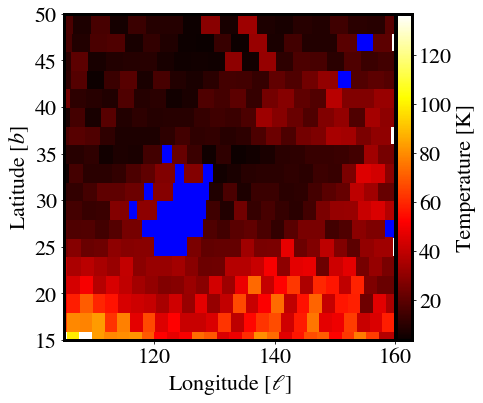

In [9]:
plt.figure(figsize=(7,6))
plt.scatter(coords[:,0], coords[:,1], s=300, marker="s", color="blue")
plt.scatter(valid_coords[:,0], valid_coords[:,1], s=350, marker="s", c=Temps, cmap="hot")
plt.xlabel("Longitude [$\\ell$]")
plt.ylabel("Latitude [$b$]")
plt.colorbar(label="Temperature [K]", pad=0.001)
plt.xlim(105, 160)
plt.ylim(15,50)
plt.show()

## Interpolate Data

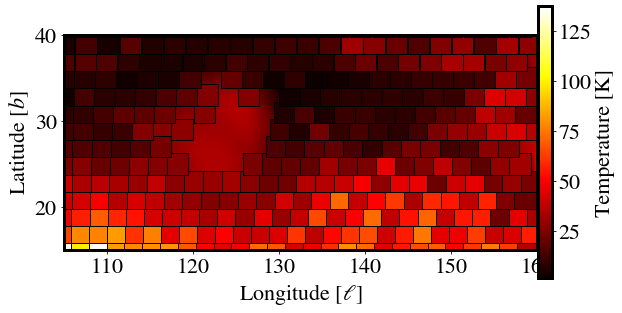

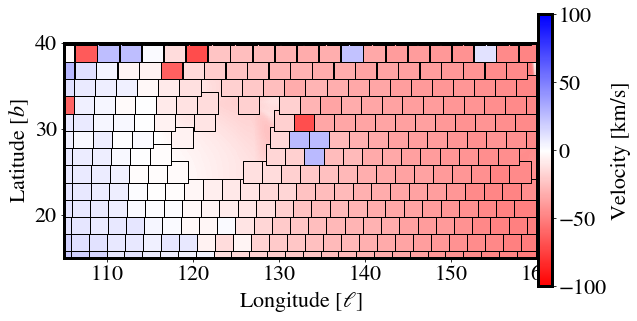

In [10]:
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

xmin,xmax = 105,160
ymin,ymax = 15,40

grid = griddata(valid_coords, Temps, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], cmap="hot", aspect="equal")
ax.scatter(valid_coords
           [:,0],valid_coords[:,1], edgecolor='black',marker="s",s = 450,c=Temps, cmap="hot")
plt.colorbar(im, label="Temperature [K]", pad=0.001)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()

grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

grid = griddata(valid_coords, vels, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], 
               cmap="bwr_r", aspect="equal", vmin=-100, vmax=100)
ax.scatter(valid_coords[:,0],valid_coords[:,1], 
           edgecolor='black',marker="s",s = 450,c=vels,
           cmap="bwr_r", vmin=-100, vmax=100)
plt.colorbar(im, label="Velocity [km/s]", pad=0.001)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()



In [14]:
import astropy.units as u
from astropy.coordinates import SkyCoord
gc = SkyCoord(l=valid_coords[:,0] * u.degree, b=valid_coords[:,1] * u.degree, frame='galactic')
vRAs = gc.fk5.ra.value 
vDECs = gc.fk5.dec.value

gc = SkyCoord(l=coords[:,0] * u.degree, b=coords[:,1] * u.degree, frame='galactic')
RAs = gc.fk5.ra.value 
DECs = gc.fk5.dec.value

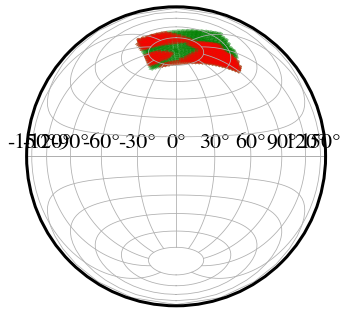

In [16]:
from matplotlib.patches import Rectangle


f = plt.figure(figsize=(9,5.5))
ax = plt.subplot(111, projection="lambert")
ax.grid(True)
for i in range(len(coords[:,0])):
    gal = SkyCoord(coords[i,0]*u.degree, coords[i,1]*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    color="green"



    

    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                             edgecolor = color,
                             facecolor = color,
                             alpha=0.5,
                             fill=True,
                             lw=3))
    
for i in range(len(valid_coords[:,0])):
    gal = SkyCoord(valid_coords[i,0]*u.degree, valid_coords[i,1]*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    color="red"


    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                             edgecolor = color,
                             facecolor = color,
                             alpha=0.5,
                             fill=True,
                             lw=3))
    


In [2]:
# import cartopy.feature as cfeature

# ax = plt.axis(projection=ccrs.Orthographic(0, 90))
# ax.add_feature(cfeature.LAND.with_scale('110m'))
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.scatter(x=10,y=45)

In [1]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# import matplotlib.pyplot as plt

# rotated_crs = ccrs.RotatedPole(pole_longitude=120.0, pole_latitude=70.0)
# ax0 = plt.axes(projection=rotated_crs)
# ax0.set_extent([-6, 1, 47.5, 51.5], crs=ccrs.PlateCarree())
# ax0.add_feature(cfeature.LAND.with_scale('110m'))
# ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)